<a href="https://colab.research.google.com/github/ROHIT-ONGIT/AI-powered-predictive-maintenance-system-using-machine-learning/blob/main/RUL_predictions_using_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries

import numpy as np
import pandas as pd
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import load
from pickle import dump
from sklearn.tree import export_text
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import ensemble
from sklearn.tree import export_text
import sklearn.metrics



convert NASA's matlab  data to panda dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Datasets/battery/' # Assuming the .mat file is in a folder named 'battery' inside 'Datasets' in  Google Drive

def load_battery_data(battery_id):
    from scipy.io import loadmat
    import pandas as pd
    import datetime
    import numpy as np

    path = folder_path + battery_id + '.mat'
    mat_data = loadmat(path)
    print(f"Total discharge cycles found: {len(mat_data[battery_id][0, 0]['cycle'][0])}")

    records, capacities = [], []
    cycle_index = 0

    for cycle in mat_data[battery_id][0, 0]['cycle'][0]:
        if cycle['type'][0] != 'discharge':
            continue

        ambient_temp = cycle['ambient_temperature'][0][0]
        raw_time = cycle['time'][0]
        # Convert the seconds component to an integer safely by rounding

        seconds = int(np.round(raw_time[5]))

        timestamp = datetime.datetime(*(int(v) for v in raw_time[:5])) + datetime.timedelta(seconds=seconds)

        data_block = cycle['data'][0, 0]
        capacity = data_block['Capacity'][0][0]

        for i in range(len(data_block['Voltage_measured'][0])):
            records.append([
                cycle_index + 1,
                ambient_temp,
                timestamp,
                capacity,
                data_block['Voltage_measured'][0][i],
                data_block['Current_measured'][0][i],
                data_block['Temperature_measured'][0][i],
                data_block['Current_load'][0][i],
                data_block['Voltage_load'][0][i],
                data_block['Time'][0][i]
            ])

        capacities.append([cycle_index + 1, ambient_temp, timestamp, capacity])
        cycle_index += 1


    df_full = pd.DataFrame(records, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity',
        'voltage_measured', 'current_measured', 'temperature_measured',
        'current_load', 'voltage_load', 'time'
    ])

    df_capacity = pd.DataFrame(capacities, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity'
    ])

    return df_full, df_capacity

Mounted at /content/drive


In [4]:
dataset, capacity = load_battery_data('B0005')

Total discharge cycles found: 616


# Describing data

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cycle                 50285 non-null  int64         
 1   ambient_temperature   50285 non-null  uint8         
 2   datetime              50285 non-null  datetime64[ns]
 3   capacity              50285 non-null  float64       
 4   voltage_measured      50285 non-null  float64       
 5   current_measured      50285 non-null  float64       
 6   temperature_measured  50285 non-null  float64       
 7   current_load          50285 non-null  float64       
 8   voltage_load          50285 non-null  float64       
 9   time                  50285 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), uint8(1)
memory usage: 3.5 MB


In [ ]:
dataset.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:42,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:42,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:42,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:42,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:42,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [ ]:
dataset.describe()  # for statics

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,2008-05-07 01:58:44.091975680,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
min,1.000000,24.0,2008-04-02 15:25:42,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,2008-04-29 22:00:05,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,2008-05-07 21:56:10,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,2008-05-18 03:05:19,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,2008-05-27 20:45:42,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000
std,45.699687,0.0,NaN,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295


Data Screening

In [ ]:
# Checking for null values
features = ['cycle', 'ambient_temperature',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null))

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]
print('Size of cleaned dataset: ', N)

The dataset contains 0 null values
The dataset contains 0 duplicates
Size of cleaned dataset:  50285


Correlation matrix and heatmap

In [ ]:
dataset[features].corr()

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
cycle,1.000000,NaN,-0.986857,-0.132877,0.127769,0.139936,0.455661,-0.177385,-0.119383
ambient_temperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capacity,-0.986857,NaN,1.000000,0.135859,-0.132162,-0.143717,-0.407819,0.181684,0.119542
voltage_measured,-0.132877,NaN,0.135859,1.000000,-0.091667,-0.914580,-0.034467,0.384095,-0.817528
current_measured,0.127769,NaN,-0.132162,-0.091667,1.000000,0.354628,-0.350758,-0.917754,0.416898
temperature_measured,0.139936,NaN,-0.143717,-0.914580,0.354628,1.000000,-0.091684,-0.601707,0.915537
current_load,0.455661,NaN,-0.407819,-0.034467,-0.350758,-0.091684,1.000000,0.289994,-0.225579
voltage_load,-0.177385,NaN,0.181684,0.384095,-0.917754,-0.601707,0.289994,1.000000,-0.628276
time,-0.119383,NaN,0.119542,-0.817528,0.416898,0.915537,-0.225579,-0.628276,1.000000


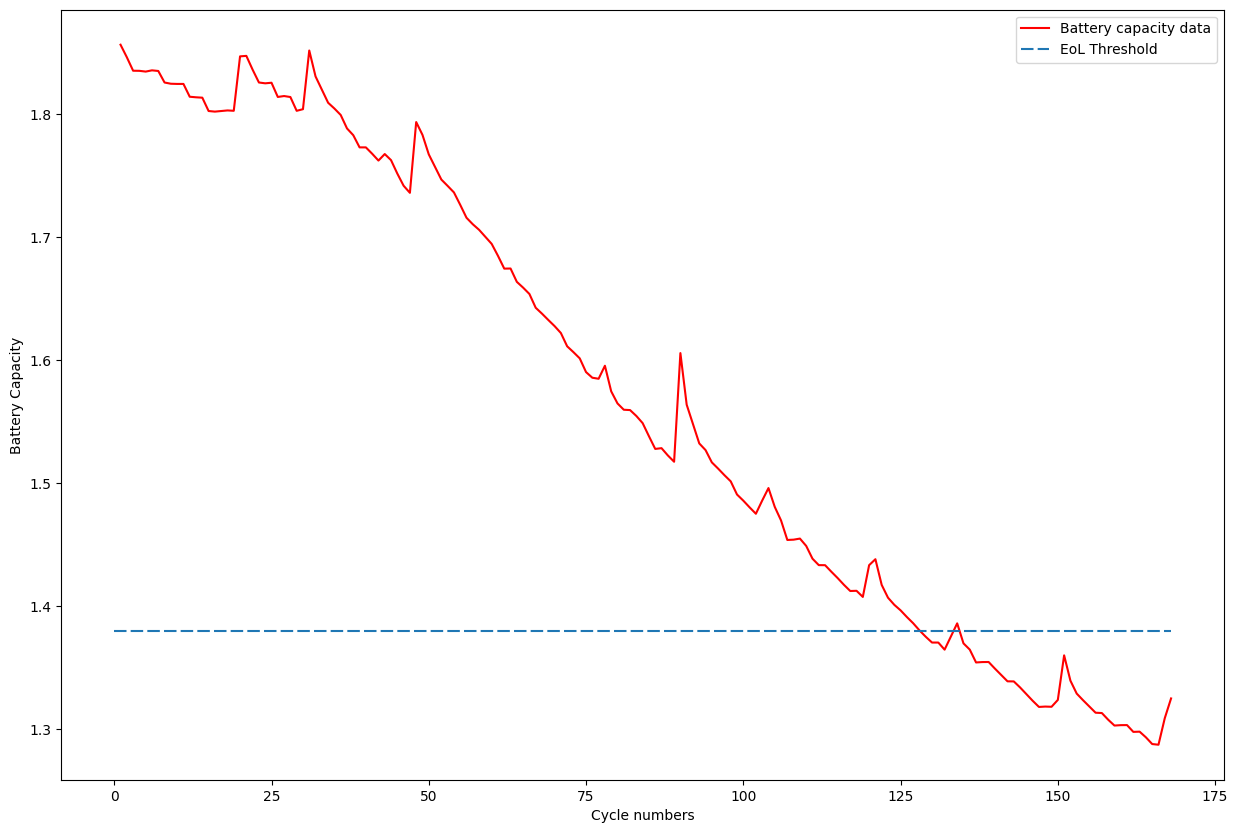

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(dataset[['cycle']], dataset[['capacity']] , color='red', label='Battery capacity data')
ax.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="EoL Threshold")
ax.set(xlabel='Cycle numbers', ylabel='Battery Capacity')
ax.legend()


In [ ]:
dataset[features].corr()

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
cycle,1.000000,NaN,-0.986857,-0.132877,0.127769,0.139936,0.455661,-0.177385,-0.119383
ambient_temperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capacity,-0.986857,NaN,1.000000,0.135859,-0.132162,-0.143717,-0.407819,0.181684,0.119542
voltage_measured,-0.132877,NaN,0.135859,1.000000,-0.091667,-0.914580,-0.034467,0.384095,-0.817528
current_measured,0.127769,NaN,-0.132162,-0.091667,1.000000,0.354628,-0.350758,-0.917754,0.416898
temperature_measured,0.139936,NaN,-0.143717,-0.914580,0.354628,1.000000,-0.091684,-0.601707,0.915537
current_load,0.455661,NaN,-0.407819,-0.034467,-0.350758,-0.091684,1.000000,0.289994,-0.225579
voltage_load,-0.177385,NaN,0.181684,0.384095,-0.917754,-0.601707,0.289994,1.000000,-0.628276
time,-0.119383,NaN,0.119542,-0.817528,0.416898,0.915537,-0.225579,-0.628276,1.000000


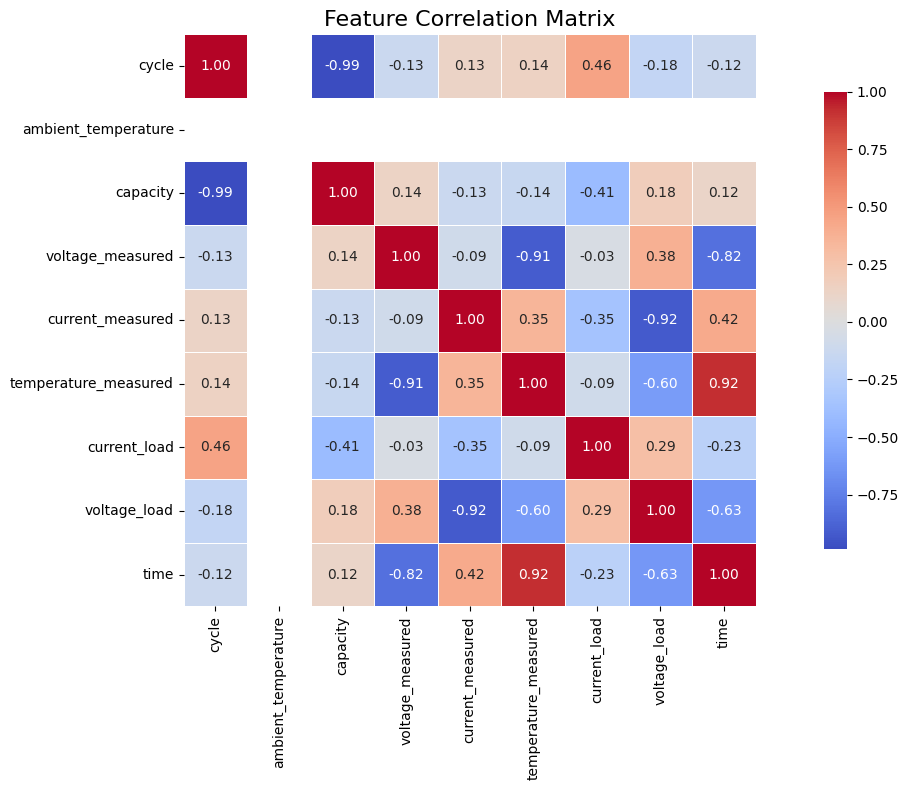

In [ ]:
# Heatmap for feature correlation
plt.figure(figsize=(14, 8))
correlation_matrix = dataset[features].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cmap='coolwarm',
    vmax=1.0,
    linewidths=0.5,
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)

plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()


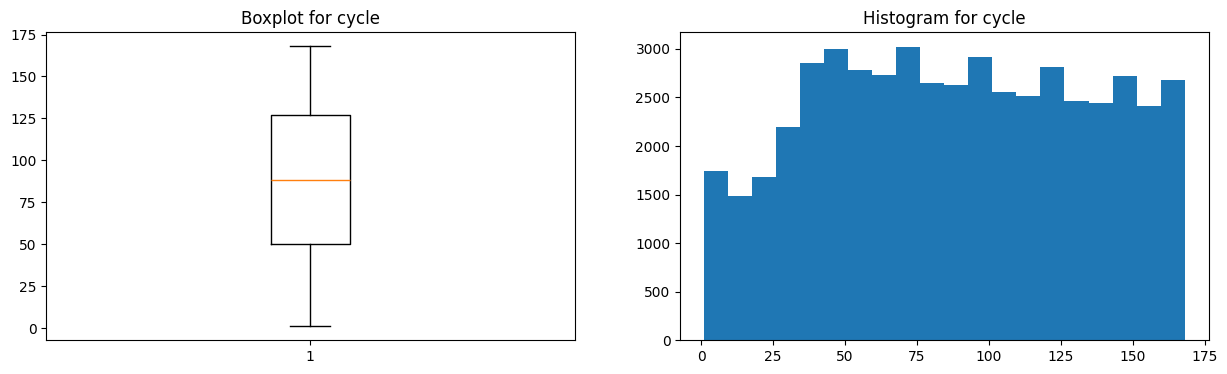

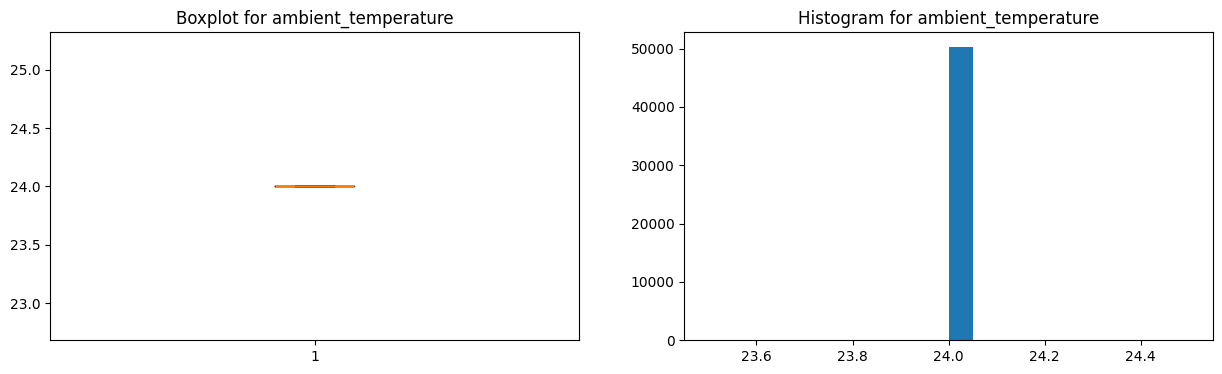

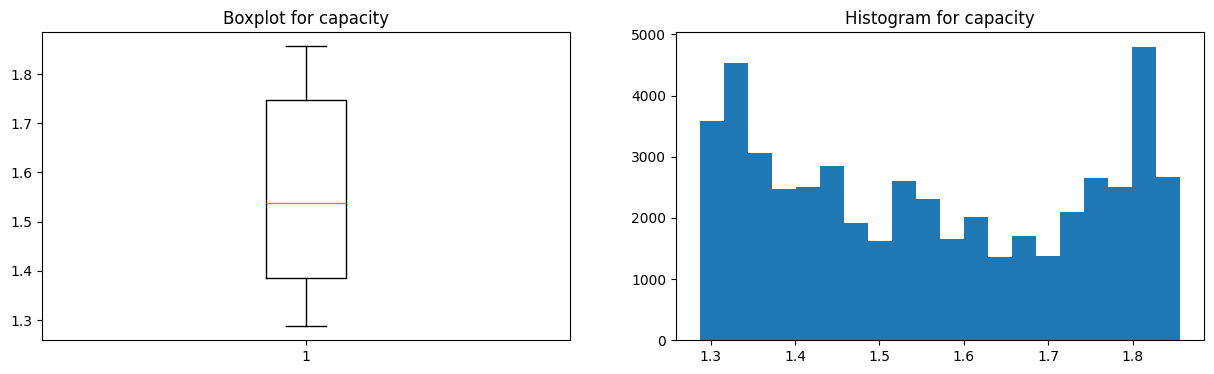

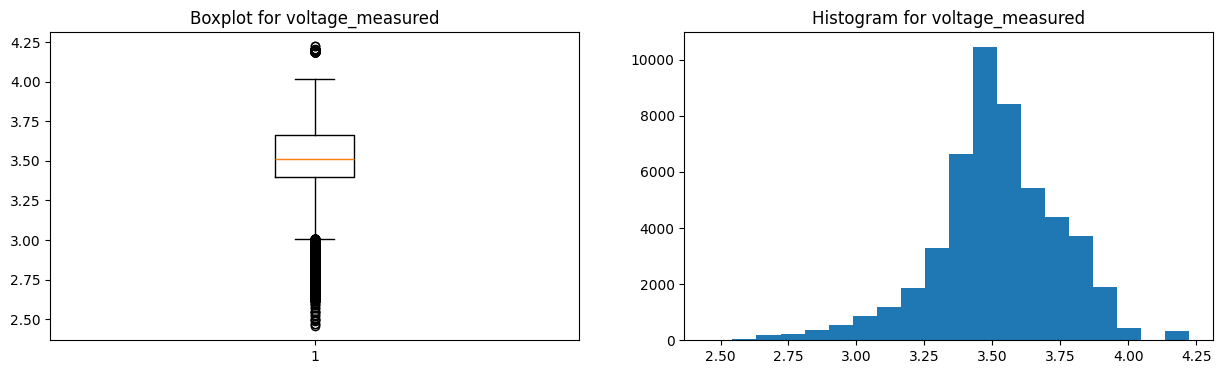

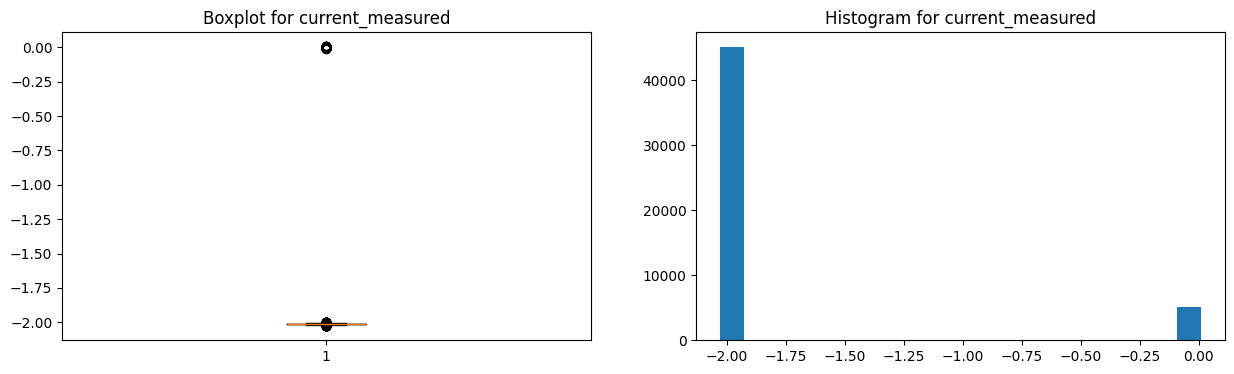

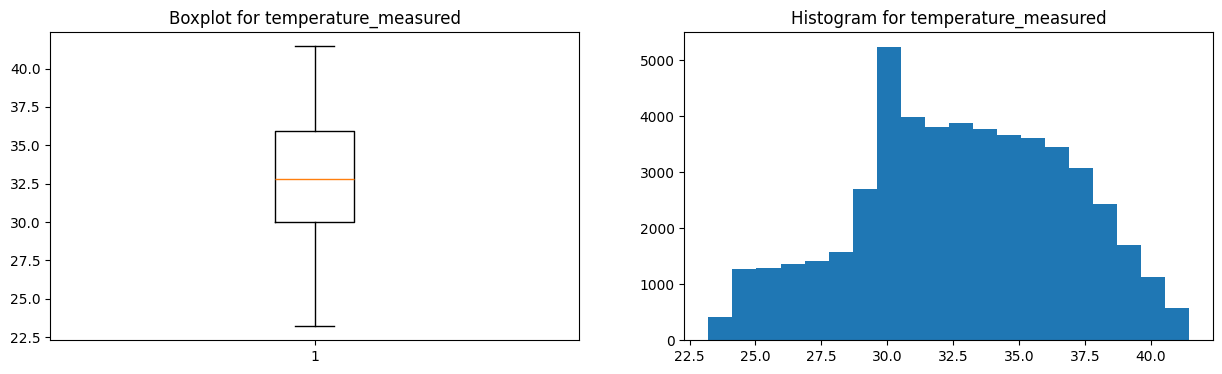

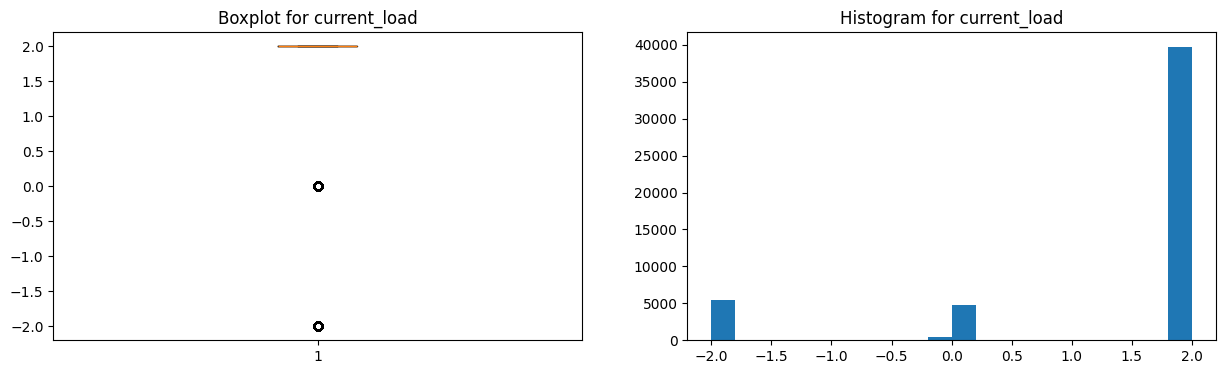

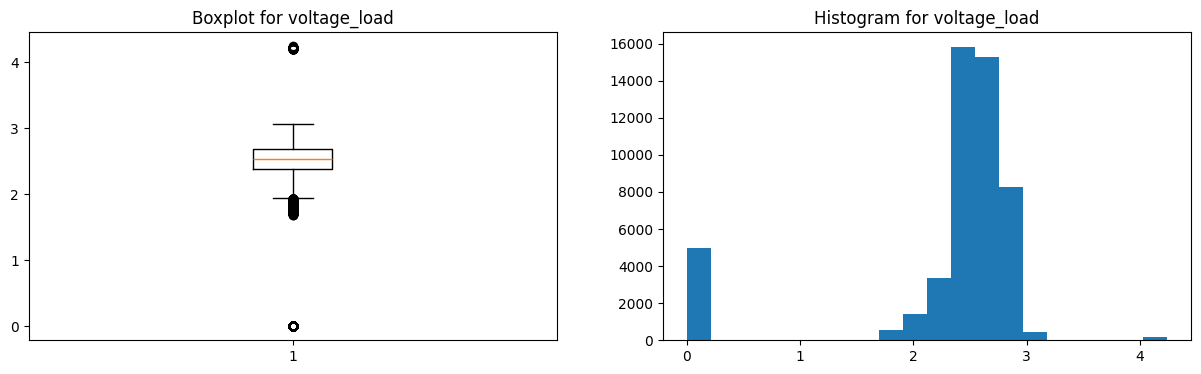

In [ ]:
# visuaising the data by plotting Boxpot and histogram of each feature

for feature in ['cycle', 'ambient_temperature', 'capacity', 'voltage_measured', 'current_measured',
                    'temperature_measured', 'current_load', 'voltage_load']:
    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = dataset[feature].values

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )



    # Display
    plt.show()

Feature Selection



In [ ]:

X = dataset[['cycle', 'ambient_temperature',
                                 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']]
y = dataset['capacity']

In [ ]:
#importing randomForest
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)

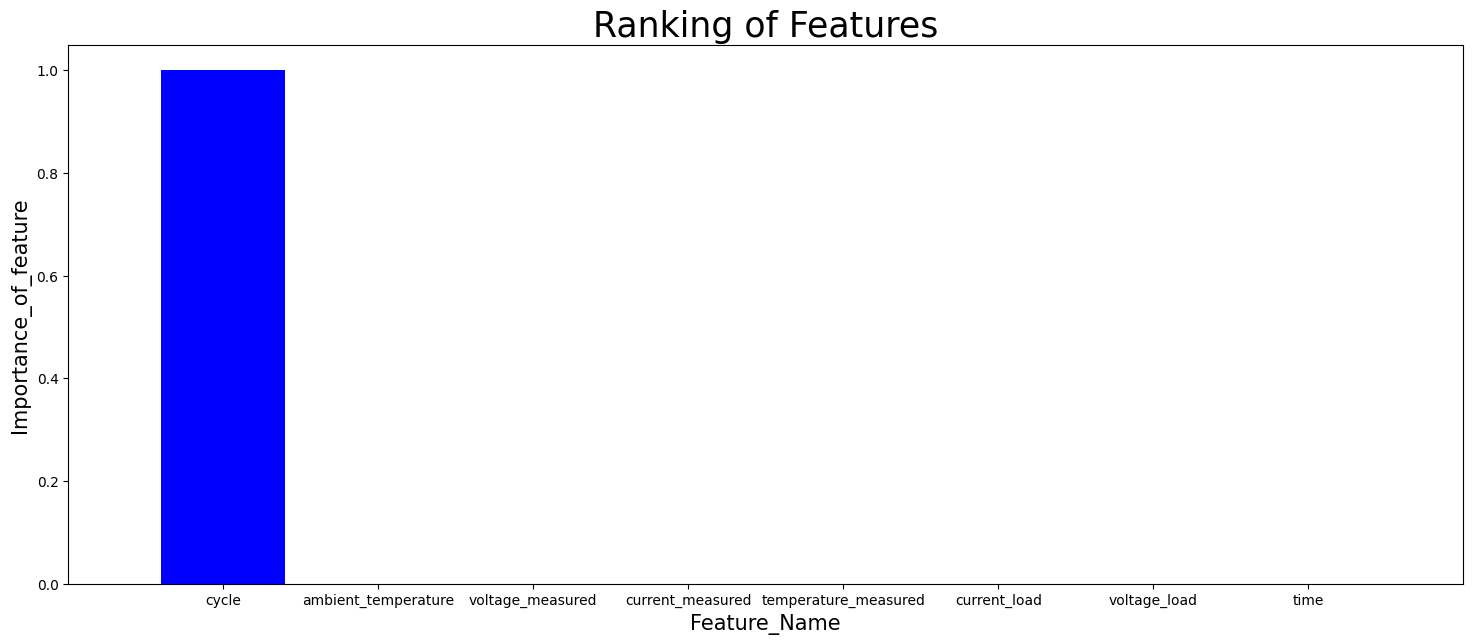

In [ ]:
# knowing the  feature importance to select the features

importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
f, ax = plt.subplots(figsize=(18, 7))
plt.title("Ranking of Features", fontsize = 25)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), feature_names)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance_of_feature", fontsize = 15)
plt.xlabel("Feature_Name", fontsize = 15)
plt.show()

order  of importance

In [ ]:
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

cycle                   9.998871e-01
current_load            1.128698e-04
current_measured        1.061945e-08
voltage_measured        6.803221e-14
temperature_measured    6.669338e-14
time                    6.164224e-14
voltage_load            5.860504e-14
ambient_temperature     0.000000e+00
dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
X_train

,cycle,ambient_temperature,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922
...,...,...,...,...,...,...,...,...
40223,135,24,3.360799,-2.010457,36.185453,1.9982,2.398,1855.031
40224,135,24,3.358384,-2.012746,36.238577,1.9982,2.396,1864.406
40225,135,24,3.356175,-2.012531,36.295522,1.9982,2.394,1873.703
40226,135,24,3.353691,-2.012193,36.352229,1.9982,2.392,1883.063


In [ ]:
X_test

,cycle,ambient_temperature,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
40228,135,24,3.348997,-2.011760,36.448980,1.9980,2.387,1901.828
40229,135,24,3.346386,-2.012456,36.507417,1.9982,2.384,1911.219
40230,135,24,3.343825,-2.014181,36.559807,1.9982,2.382,1920.609
40231,135,24,3.341496,-2.011917,36.622468,1.9982,2.380,1929.969
40232,135,24,3.338640,-2.012436,36.671214,1.9982,2.377,1939.359
...,...,...,...,...,...,...,...,...
50280,168,24,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312
50281,168,24,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062
50282,168,24,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828
50283,168,24,3.587336,0.001219,34.565580,0.0006,0.000,2810.640


Saving the data to a pickle file

In [ ]:
import os
from pickle import dump # Import dump

# Create the directory if it doesn't exist
os.makedirs("pickle/dataset/battery/", exist_ok=True)

dump(X_train, open("pickle/dataset/battery/X_train.pkl", "wb"))
dump(y_train, open("pickle/dataset/battery/y_train.pkl", "wb"))
dump(X_test, open("pickle/dataset/battery/X_test.pkl", "wb"))
dump(y_test, open("pickle/dataset/battery/y_test.pkl", "wb"))

In [ ]:
import os

os.makedirs("pickle/dataset/battery/", exist_ok=True)

XGBRegressor

In [ ]:
# load data
from pickle import load # Import load

X_train = load(open('pickle/dataset/battery/X_train.pkl', 'rb'))
y_train = load(open('pickle/dataset/battery/y_train.pkl', 'rb'))
X_test = load(open('pickle/dataset/battery/X_test.pkl', 'rb'))
y_test = load(open('pickle/dataset/battery/y_test.pkl', 'rb'))

In [ ]:
# Load dataset and extract X, y
dataset, _ = load_battery_data('B0005')
X = dataset[['cycle']]
y = dataset['capacity']


Total discharge cycles found: 616


In [ ]:
# This code has been moved to cell dD3CpvWu1S5V to ensure that the 'pre' column is created before it is accessed.
actual_cycles = dataset['capacity'].values
predicted_cycles = dataset['pre'].values

# Initialize fail cycle values
Afil = Pfil = None

# Find actual failure cycle
for i, cap in enumerate(actual_cycles):
    if cap <= 1.38:
        Afil = dataset.loc[i, 'cycle']
        break

# Find predicted failure cycle
for i, pred in enumerate(predicted_cycles):
    if pred <= 1.38:
        Pfil = dataset.loc[i, 'cycle']
        break

# Output results
if Afil is not None and Pfil is not None:
    print("The Actual fail at cycle number:", Afil)
    print("The Prediction fail at cycle number:", Pfil)
    print("The error of RUL =", Pfil - Afil, "Cycle(s)")
else:
    print("Failure threshold not reached in actual or predicted data.")

The Actual fail at cycle number: 129
The Prediction fail at cycle number: 127
The error of RUL = -2 Cycle(s)


SVM Regressor

In [ ]:
svr = SVR(C=20, epsilon=0.0001, gamma=0.00001, cache_size=200,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(X_train,y_train)

SVR(C=20, epsilon=0.0001, gamma=1e-05)

In [ ]:
import pandas as pd # Import pandas

y_pred = svr.predict(pd.concat([X_train, X_test])) # Changed append to pd.concat

In [ ]:
a = dataset['capacity'].values
b = dataset['pre'].values
cycles = dataset['cycle'].values

Afil = next(cycles[i] for i, val in enumerate(a) if val <= 1.38)
Pfil = next(cycles[i] for i, val in enumerate(b) if val < 1.38)

print(f"Actual failure at cycle: {Afil}")
print(f"Predicted failure at cycle: {Pfil}")
print(f"RUL Error: {Pfil - Afil} cycle(s)")


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

for name, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
    preds = svr.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    print(f'{name} RMSE: {rmse:.3f}')
    print(f'{name} R² Score: {r2:.3f}')


In [ ]:
from sklearn.linear_model import LassoLarsCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import pandas as pd # Import pandas

# Re-create the pipeline
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LassoLarsCV()
)


# Fit the pipeline
exported_pipeline.fit(X_train, y_train)

# Predict
results = exported_pipeline.predict(pd.concat([X_train, X_test], ignore_index=True))

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
X_all = pd.concat([X_train, X_test], ignore_index=True)
y_all = pd.concat([y_train, y_test], ignore_index=True)

ax.plot(X_all['cycle'], y_all, 'b--', lw=2, label='Actual')
ax.plot(X_all['cycle'], y_pred, 'orange', lw=2, marker='o', ms=3, label='Predicted')
ax.axhline(1.38, color='crimson', ls=':', lw=2, label='EoL Threshold')

ax.set(xlabel='Cycle', ylabel='Capacity', title='Battery Capacity Prediction')
ax.legend()
ax.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.linear_model import LassoLarsCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import pandas as pd # Import pandas
import sklearn.metrics # Import sklearn.metrics
import numpy as np # Import numpy
from sklearn.metrics import mean_squared_error # Import mean_squared_error


# Re-create the pipeline
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LassoLarsCV()
)

# OPTIONAL: Fit an initial model like XGB to create engineered features manually if you still want that behavior
# But since you asked for a version without StackingEstimator, it's safe to remove it

# Fit the pipeline
exported_pipeline.fit(X_train, y_train)


# Make predictions on the full dataset using the exported_pipeline
# Use the same features as were used for training
X_full = dataset[['cycle', 'ambient_temperature',
                                 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']]
predicted_capacity_per_measurement = exported_pipeline.predict(X_full)


# Assign the predictions to a new column in the dataset DataFrame
dataset['pre'] = predicted_capacity_per_measurement

# Calculate the mean predicted capacity for each cycle
predicted_capacity_per_cycle = dataset.groupby('cycle')['pre'].mean().reset_index()

# Merge the actual capacity data with the predicted capacity per cycle
merged_capacity = capacity.merge(predicted_capacity_per_cycle, on='cycle', how='left')

# Actual failure cycle
actual_failure_cycles = merged_capacity.loc[merged_capacity['capacity'] <= 1.38, 'cycle']
Afil = actual_failure_cycles.iloc[0] if not actual_failure_cycles.empty else None

# Predicted failure cycle
predicted_failure_cycles = merged_capacity.loc[merged_capacity['pre'] < 1.38, 'cycle']
Pfil = predicted_failure_cycles.iloc[0] if not predicted_failure_cycles.empty else None


if Afil is not None and Pfil is not None:
    print(f"The Actual fail at cycle number: {Afil}")
    print(f"The prediction fail at cycle number: {Pfil}")
    print(f"The error of RUL = {Pfil - Afil} Cycle(s)")
else:
    print("Failure threshold not reached in actual or predicted data.")

# Evaluate the model's performance using RMSE and R²
train_predictions = exported_pipeline.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print('Train RMSE: %.3f' % rmse)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

test_predictions = exported_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print('Test RMSE: %.3f' % rmse)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

# Moving code from cell tJI0pQJ5dq6E here
actual_cycles = dataset['capacity'].values
predicted_cycles = dataset['pre'].values

# Initialize fail cycle values
Afil_orig = Pfil_orig = None

# Find actual failure cycle
for i, cap in enumerate(actual_cycles):
    if cap <= 1.38:
        Afil_orig = dataset.loc[i, 'cycle']
        break

# Find predicted failure cycle
for i, pred in enumerate(predicted_cycles):
    if pred <= 1.38:
        Pfil_orig = dataset.loc[i, 'cycle']
        break

# Output results
if Afil_orig is not None and Pfil_orig is not None:
    print("\nOriginal code output:")
    print("The Actual fail at cycle number:", Afil_orig)
    print("The Prediction fail at cycle number:", Pfil_orig)
    print("The error of RUL =", Pfil_orig - Afil_orig, "Cycle(s)")
else:
    print("Failure threshold not reached in original actual or predicted data.")

The Actual fail at cycle number: 129
The prediction fail at cycle number: 129
The error of RUL = 0 Cycle(s)
Train RMSE: 0.015
Train R2 score: 0.9903524071479156
Test RMSE: 0.035
Test R2 score: -1.6963932661474574

Original code output:
The Actual fail at cycle number: 129
The Prediction fail at cycle number: 127
The error of RUL = -2 Cycle(s)


In [ ]:
train_predictions = exported_pipeline.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print('Train RMSE: %.3f' % rmse)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

test_predictions = exported_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print('Test RMSE: %.3f' % rmse)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train RMSE: 0.015
Train R2 score: 0.9903524071479156
Test RMSE: 0.035
Test R2 score: -1.6963932661474574
